# VAE Analysis

## The previous Model and it's shortcomings. 
#### First let's load the model and plot the 5000 examples and 4 red points + 1 extra red point, from 03_02_autoencoder_analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn

from models.Autoencoder import Autoencoder
from torchvision import datasets, transforms
from scipy.stats import norm

In [2]:
test_ds = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

device = t.device('cuda') if t.cuda.is_available() else 'cpu'
prev_model = Autoencoder(test_ds[0][0][None], in_c=1, enc_out_c=[32, 64, 64, 64],
                    enc_ks=[3, 3, 3, 3], enc_pads=[1, 1, 0, 1], enc_strides=[1, 2, 2, 1],
                    dec_out_c=[64, 64, 32, 1], dec_ks=[3, 3, 3, 3], dec_strides=[1, 2, 2, 1],
                    dec_pads=[1, 0, 1, 1], dec_op_pads=[0, 1, 1, 0], z_dim=2)
prev_model.cuda(device)
prev_model.load_state_dict(t.load('models/state_dicts/03_01.pth'))
prev_model.eval()

t.set_grad_enabled(False)
encoder = prev_model.enc_conv_layers
decoder = prev_model.dec_conv_layers

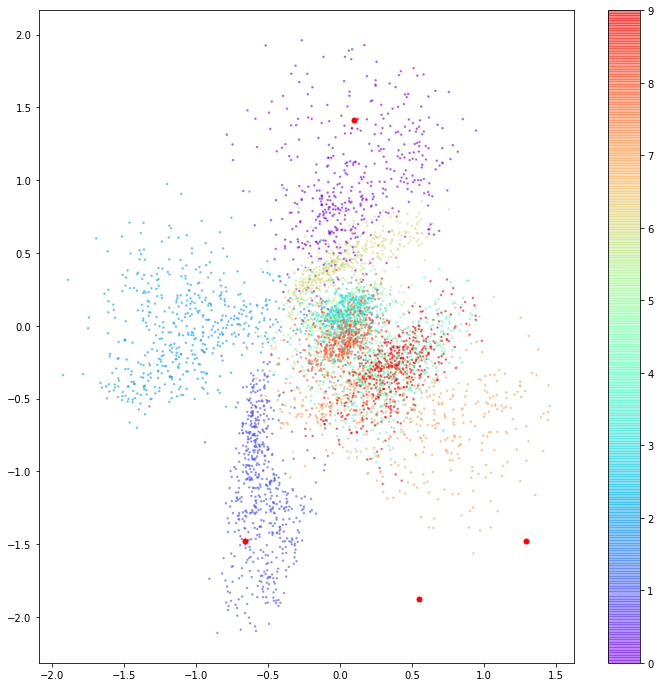

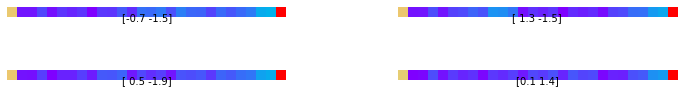

In [3]:
test_dl = t.utils.data.DataLoader(dataset=test_ds, batch_size=5000, shuffle=False, drop_last=True)

figsize = 12
np.random.seed(42)

examples = next(iter(test_dl))
x, y = examples[0], examples[1]
z_points = encoder(x.to(device)).cpu()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=y, alpha=0.5, s=2)
plt.colorbar()

grid_size = 2
grid_depth = 2

zx_min, zx_max, zy_min, zy_max = min(z_points[:, 0]), max(z_points[:, 0]), min(z_points[:, 1]), max(z_points[:, 1])
x = np.random.uniform(zx_min, zx_max, size = grid_size * grid_depth)
y = np.random.uniform(zy_min, zy_max, size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = decoder(t.from_numpy(z_grid).float().to(device)).cpu()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=25)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)    
    ax.imshow(reconst[i, :,:,0], cmap = 'rainbow')

[-0.7 -1.5]	     [ 1.3 -1.5]	     [ 0.5 -1.9]	     [0.1 1.4]	     

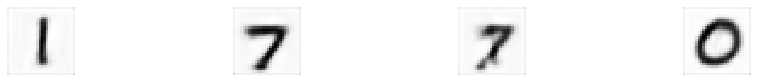

In [4]:
z_points = t.tensor([[-.7, -1.5], [1.3, -1.5], [.5, -1.9], [0.1, 1.4]])
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t     ')
    
for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


In [5]:
zx_min, zx_max, zy_min, zy_max

(tensor(-1.9228), tensor(1.4542), tensor(-2.1091), tensor(1.9611))

## Now we ask the question, why did [0.5, -1.9], the 7 look off?
### First as discussed, [.5, -1.9] is an outlier, from clusters within our zx_min, zx_max, zy_min and zy_max bounds.
### The underlying issue is that, the model is not as confident as it could be when picking points that are in a discontinous latent space because it wasn't trained to pick out points from there and decode properly. Let's test this theory again with plotting decoded spaces, truly close to the bounds. 

[-1.9228177 -2.1090848]	         [-1.9228177  1.4541827]	         [ 1.4541827 -2.1090848]	         [1.4541827 1.961089 ]	         

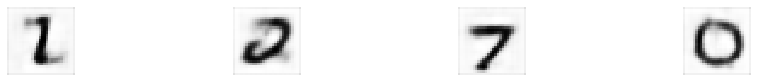

In [6]:
z_points = t.tensor([[zx_min, zy_min], [zx_min, zx_max], [zx_max, zy_min], [zx_max, zy_max]])
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t         ')
    
for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


#### Above you can see the numbers have smears of black, and the first two are not really clear what number it's to be

## So now, coming back to the problem again. You can see from the rainbow colored cluster graph that it isn't densely packed and there are a lot of discontinuous spaces. The outlier itself isn't the issue, as you'll see that even addressing this issue, you will have outliers, but what you don't want is discontinuous spaces between clusters.


### Essentially our Neural network didn't have enough say in how to make a properly dense, but distinct clusters(w.r.t. a continous scale) for our number images. 

### To address this, first, we added the Lambda layer from VariationalAutoencoder.py that helps us sample similar points for similar images when trained. The two vectors, mu and log_var, gives a multivariate normal distribution around some point in the latent space, which is a mapping that randomly distributes some sample spaces for the encodings, close to the mu(mean) vs just a straight 1-vector(two points) mapping as we had before. Now remember a net's job is to reduce loss, however if our loss doesn't tell it to try to map similar images to similar distributions of point spaces, it can't disperse and cluster well around those points. So how do we tell that? 

### Well it turns out, we don't tell much of that, it's something the net figures out as training. However, we can actually augment it, as well as add another nice to have on the global latent space.

### We first add to our loss function, another loss(KL div) that makes it so that our Net has to be trained in a way to optimize the probability distribution params mu and log_var to resemble the target distributions. This by itself, will try to just cluster around the same center, but as you saw from the rainbow graph above, training a encoder and decoder just happens to try to encode similar things to a similar cluster. With that in mind, we now train with both KL div and the regular loss(can use BCE or MSE, but I found BCE works better. This trick(sigmoid scaling) is used a lot to train faster and better in other domains). This means that we will have a densly packed area in terms of the whole latent space, while maintaining well formed clusters within in, with the power of continuous ranges of encoding for similar images.

## Now, with Variational Auto Encoding

In [7]:
import torch as t
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from models.VariationalAutoencoder import VariationalAutoencoder
from torchvision import datasets, transforms


In [8]:
test_ds = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

device = t.device('cuda') if t.cuda.is_available() else 'cpu'
model = VariationalAutoencoder(test_ds[0][0][None], in_c=1, enc_out_c=[32, 64, 64, 64],
                    enc_ks=[3, 3, 3, 3], enc_pads=[1, 1, 0, 1], enc_strides=[1, 2, 2, 1],
                    dec_out_c=[64, 64, 32, 1], dec_ks=[3, 3, 3, 3], dec_strides=[1, 2, 2, 1],
                    dec_pads=[1, 0, 1, 1], dec_op_pads=[0, 1, 1, 0], z_dim=2)
model.cuda(device)
model.load_state_dict(t.load('models/state_dicts/03_03.pth'))
model.eval()

t.set_grad_enabled(False)
encoder = model.enc_conv_layers
decoder = model.dec_conv_layers

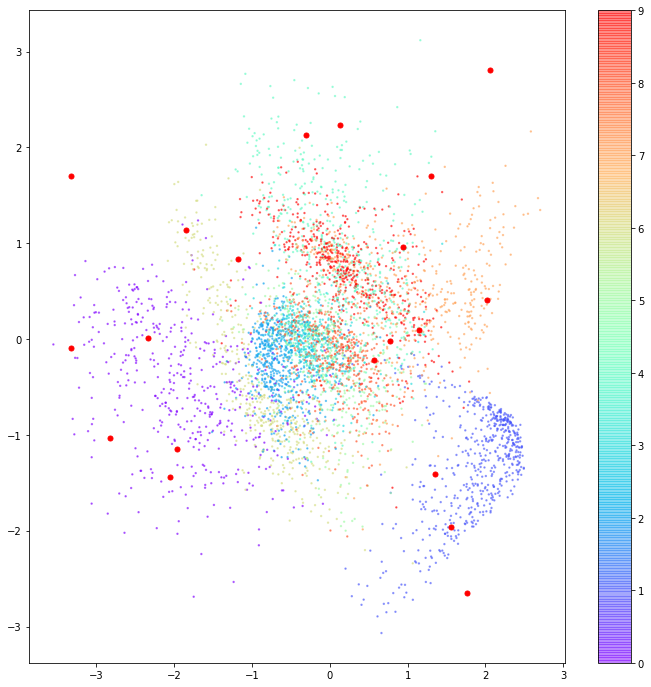

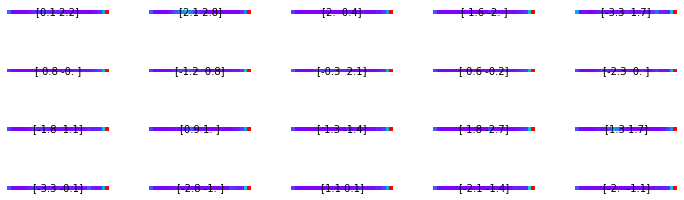

In [9]:
test_dl = t.utils.data.DataLoader(dataset=test_ds, batch_size=5000, shuffle=False, drop_last=True)

figsize = 12
np.random.seed(20)

examples = next(iter(test_dl))
x, y = examples[0], examples[1]
z_points = encoder(x.to(device))[0].cpu()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=y, alpha=0.5, s=2)
plt.colorbar()

grid_size = 5
grid_depth = 4

zx_min, zx_max, zy_min, zy_max = min(z_points[:, 0]), max(z_points[:, 0]), min(z_points[:, 1]), max(z_points[:, 1])
x = np.random.uniform(zx_min, zx_max, size = grid_size * grid_depth)
y = np.random.uniform(zy_min, zy_max, size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = decoder(t.from_numpy(z_grid).float().to(device)).cpu()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=25)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)    
    ax.imshow(reconst[i, :,:,0], cmap = 'rainbow')

[0.12856504 2.23727   ]	     [2.0635169 2.8073583]	     [2.0248718  0.40650773]	     [ 1.5517747 -1.9622618]	     [-3.323047   1.6967517]	     [ 0.776252   -0.02223814]	     [-1.1805362  0.8368645]	     [-0.3065722  2.1251276]	     [ 0.5649574  -0.21612664]	     [-2.335763    0.01215165]	     [-1.8453345  1.1347841]	     [0.94405925 0.9577003 ]	     [ 1.3465569 -1.4054047]	     [ 1.7673448 -2.65176  ]	     [1.2980634 1.7041333]	     [-3.3182046  -0.09274272]	     [-2.8180056 -1.0316837]	     [1.1482828  0.09072361]	     [-2.0522046 -1.4373657]	     [-1.9547778 -1.1473355]	     

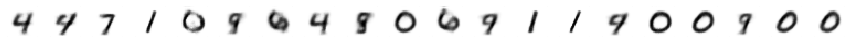

In [10]:
z_points = t.tensor(z_grid).float()
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t     ')
    
for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


In [11]:
zx_min, zx_max, zy_min, zy_max

(tensor(-3.5474), tensor(2.7028), tensor(-3.0682), tensor(3.1180))

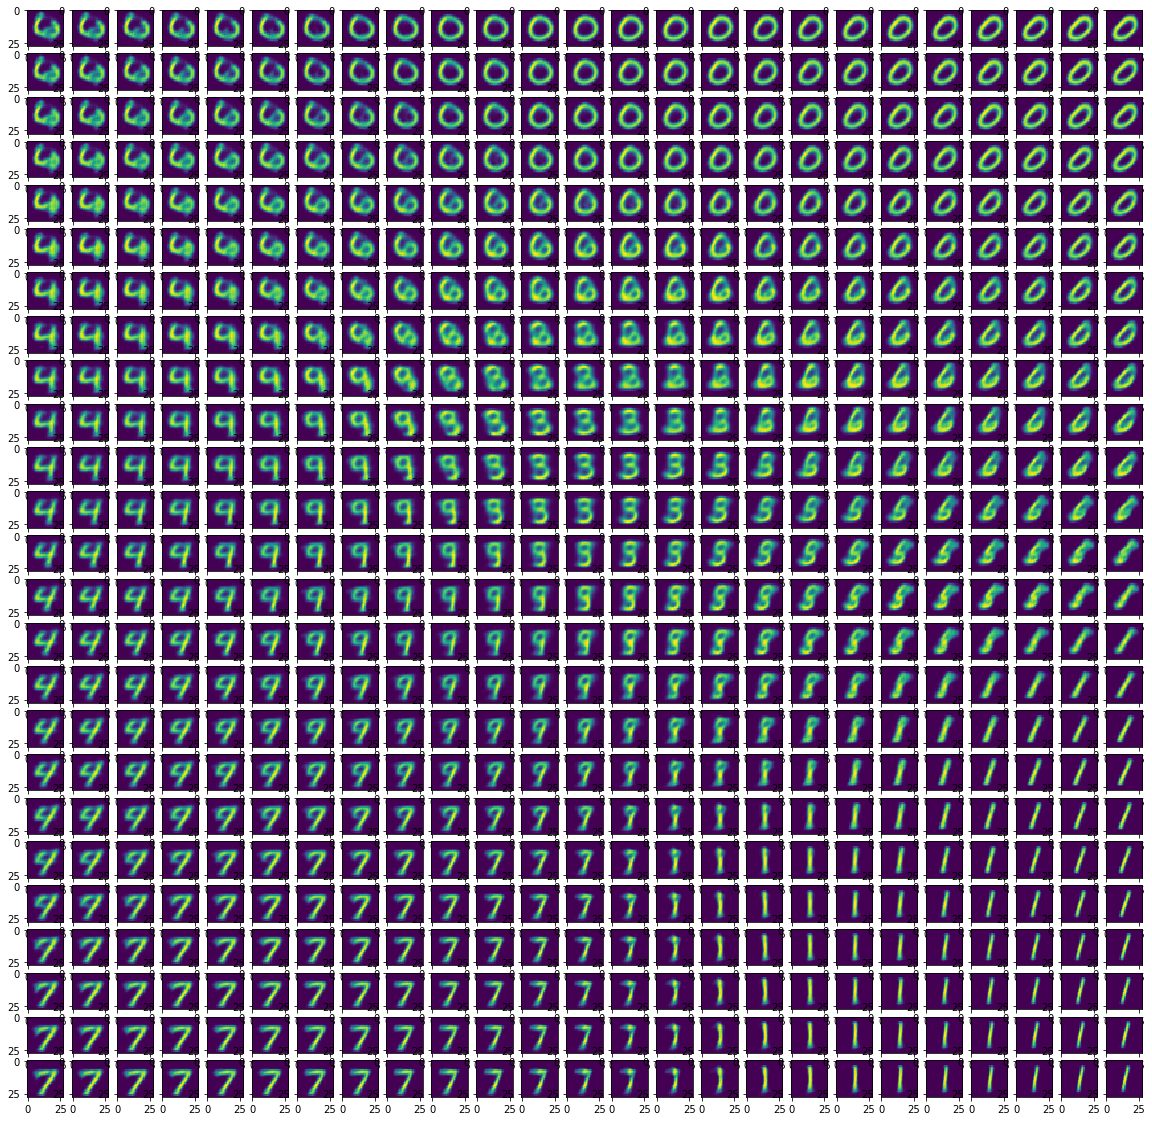

In [12]:
row, col = 25, 25
z_points = t.tensor([[a,b] for a in np.linspace(zx_min + 1 , zx_max, row) for b in np.linspace(zy_max - 1, zy_min + 1, col)])

bs = len(z_points)
with t.no_grad():
    reconst_imgs = decoder(z_points.to(device))

f, axarr = plt.subplots(row, col, figsize=(20,20))
i = 0
for r in range(row):
    for c in range(col):
        axarr[r, c].imshow(reconst_imgs[i].cpu().squeeze())
        i += 1